In [1]:
import torch
import numpy as np
import cv2
from PIL import Image
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms import Compose
from torchvision import transforms

from matplotlib import pyplot as plt

In [33]:

def label_map(index):
    index = int(index)
    if index == 0:
        return 'COMPLETE FEATURE'
    elif index == 1:
        return 'BORDERTOUCHER'
    elif index == 2:
        return 'NO FEATURE'
    else:
        return 'unkown'

    
from geometry import is_bordertoucher

In [3]:
def threshold(image, thres):
    (t, segmentation) = cv2.threshold(image, thres, 255, cv2.THRESH_BINARY)
    return segmentation

def find_contours(segmentation):
    _, contours, _ = cv2.findContours(segmentation, cv2.RETR_LIST, cv2.CHAIN_APPROX_TC89_L1)
    return contours

def find_ellipse(image, binary_threshold = 100, contour_length=5, min_area=10, circ = 0.5, p=0.5):
    
    contours = find_contours(threshold(image, binary_threshold))
    ellipses = []
    pi_4 = np.pi * 4
    ellipses_contour = image.copy()
    for i, contour in enumerate(contours):
        if len(contour) >= contour_length:
            area = cv2.contourArea(contour)
            if area >= min_area:  # skip ellipses smaller then 10x10

                arclen = cv2.arcLength(contour, True)
                circularity = (pi_4 * area) / (arclen * arclen)
                if circularity >= circ:
                    ellipses.append(ellipses_of_contour(contour))

    return ellipses

def ellipses_of_contour(contour, num_cont=5):
    if len(contour) <= num_cont:
        return None
    return cv2.fitEllipse(contour)
    
def attributes_of_ellipses(ellipses):
    center = ellipses[0]
    axis = ellipses[1]
    angle = ellipses[2]
    area = np.pi * axis[0] * axis[1]
    return center, axis, angle, area

def draw_ellipse(image, ellipses, thickness = 2, color = (255,0,0)):
    out = image.copy()
    for ell in ellipses:
        cv2.ellipse(out, ell, color, thickness)
    return out
    
def area_of_ellipse(ellipse):
    _,_,_, area = attributes_of_ellipses(ellipse)
    return area

In [15]:
def back_tf(tensor):
    tensor = tensor.detach()
    tensor = torch.sigmoid(tensor)
    
    tensor *= 255
    tensor = tensor.int()
    return tensor.numpy().astype(np.uint8)

In [42]:
def get_propability(input, contour):
    mask = np.zeros(input.shape, dtype=np.int8)
    cv2.drawContours(mask, [contour], contourIdx=-1, color=True, thickness=-1)

    el = ellipses_of_contour(contour=contour)
    area = area_of_ellipse(el)
    
    p = np.sum(input[mask]) / area
    return p

In [48]:
def detect_features(im, probs, thres=200, min_prob=0.5):
    
    binary_segmentation = threshold(im, thres)
    contours = find_contours(binary_segmentation)
    
    propabilities = []
    ellipses = []
    border_checker = []
    
    if not contours:
        return ellipses, propabilities, border_checker
    largest_area = 0
    
    largest_contour = contours[-1]
    for c in contours:
        if len(c) > 5:
            area = cv2.contourArea(c)
            if area > largest_area:
                largest_area = area 
                largest_contour = c
                
    # check for propability
    prob = get_propability(probs, largest_contour)
    
    if prob < min_prob:
        return [], [prob], [False]
    
    for c in contours:
        if len(c) > 5:
            ellipses.append(ellipses_of_contour(c))
            border_checker.append(is_bordertoucher(mask, ellipses[-1]))
            propabilities.append(prob)
            
    return ellipses, propabilities, border_checker

In [49]:
#%cd ..

In [50]:
with open("vision/train.txt") as f:
    train_imgs = [s.strip() for s in f.readlines()]
    
with open("vision/eval.txt") as f:
    eval_imgs = [s.strip() for s in f.readlines()]

In [51]:
import os

In [52]:
from vision.data_prep import DataSubSet

#data_dir = '/Users/lukassanner/Documents/ZeissHackathon/photomask_trainingdata'
data_dir = "photomask_trainingdata"

#We normalize to the mean dynamically
def normalize_dynamic(tensor_img):
    mean = torch.mean(tensor_img)
    return (tensor_img-mean)/0.1388

ds = ImageFolder(data_dir)
tf_eval = Compose([transforms.Grayscale(),
                   transforms.ToTensor(),
                   normalize_dynamic
                  ])


indexes = np.random.permutation((ds.__len__()))
ds_eval = DataSubSet(ds, [i for i in indexes if os.path.join("..", ds.samples[i][0]) in eval_imgs], transform=tf_eval)
ds_train = DataSubSet(ds, [i for i in indexes if os.path.join("..", ds.samples[i][0]) in train_imgs], transform=tf_eval)
assert len(ds_eval) + len(ds_train) == len(ds)

In [53]:
def map_location(storage, loc):
    return storage
from vision.models import SlimWide

graph_dir = 'vision/SlimWide_weakly_3.pth'
m = SlimWide()
m.load_state_dict(torch.load(graph_dir, map_location=map_location))
m.eval()

SlimWide(
  (convnet1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
  )
  (convnet2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
  )
  (convnet3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): ReLU(inplace)
  )
  (convnet4): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
)

In [54]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [78]:
img.shape

torch.Size([1, 73, 73])

In [105]:
for img, cls in [ds_eval[i] for i in range(len(ds_eval))]:
    
    with torch.no_grad():
        pred = torch.nn.functional.upsample(m(img.unsqueeze(0)), scale_factor=(2,2), mode="bilinear")
        pred = pred[0].squeeze()
    
    mask = back_tf(pred)
    probs = torch.sigmoid(pred).data.numpy()
    
    ellipses, propabilities, border_checker = detect_features(mask, probs)
    
    print(label_map(cls), ellipses, propabilities, border_checker, mask.shape)
    img_a = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    
    for ell, is_border in zip(ellipses, border_checker):
        color = (255,0,0) if is_border else (0,255,0)
        cv2.ellipse(img_a, ell, color, 2)
    
    cv2.imshow("test2", img_a)
    cv2.waitKey(1)

COMPLETE FEATURE [((48.82989501953125, 6.263674736022949), (20.343374252319336, 32.146846771240234), 105.35357666015625)] [53.51069632639903] [True] (60, 60)
BORDERTOUCHER [((59.61574172973633, 58.90840148925781), (25.211191177368164, 34.57936096191406), 44.78602600097656)] [99.31199748731792] [False] (116, 116)
BORDERTOUCHER [((54.292457580566406, 65.53627014160156), (16.05936622619629, 18.3636417388916), 72.26839447021484), ((64.37913513183594, 67.474609375), (49.79529571533203, 56.243343353271484), 150.2412872314453)] [35.21086155755461, 35.21086155755461] [False, True] (118, 118)
BORDERTOUCHER [((58.212276458740234, 65.18766021728516), (27.621051788330078, 40.38190460205078), 79.3271484375)] [155.52025011127344] [False] (128, 128)
BORDERTOUCHER [((110.73380279541016, 106.49626159667969), (9.009108543395996, 15.652850151062012), 41.544918060302734), ((11.061250686645508, 104.27674865722656), (9.930208206176758, 39.22031784057617), 115.22694396972656), ((45.5800895690918, 61.65949630

In [ ]:
#Todo: finetune ellipse/no-ellipse
#Measure accuracy of classification
#Send to API

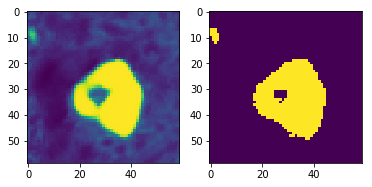

In [101]:
img, label = ds_eval.__getitem__(np.random.randint(ds_eval.__len__()))
with torch.no_grad():
    out = m(img.unsqueeze(0))
  
im = back_tf(out[0,0])
(t, segmentation) = cv2.threshold(im, 100, 255, cv2.THRESH_BINARY)
fig, ax = plt.subplots(1,2)
ax[0].imshow(im)
ax[1].imshow(segmentation)